## Face Recognition System
**Identify and authenticate users based on facial features**

This notebook implements a face recognition system that:
1. Loads facial images of different people (with various expressions)
2. Applies augmentations to increase training data robustness
3. Extracts 128D face encodings using deep learning
4. Trains a classifier to recognize different individuals
5. Tests authentication on new images

In [1]:
import face_recognition
import cv2
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt

# For suppressing warnings
import warnings
warnings.filterwarnings('ignore')

## Load and Display Facial Images
**For each person: neutral, smiling, and surprised expressions**

LOADING FACIAL IMAGES

👤 Person: Limpho
----------------------------------------
  ✅ Loaded: Neutral (limpho-neutral.jpeg) - Shape: (1600, 900, 3)
  ✅ Loaded: Smiling (limpho-smiling.jpeg) - Shape: (1600, 900, 3)
  ✅ Loaded: Surprised (limpho-suprised.jpeg) - Shape: (1600, 900, 3)


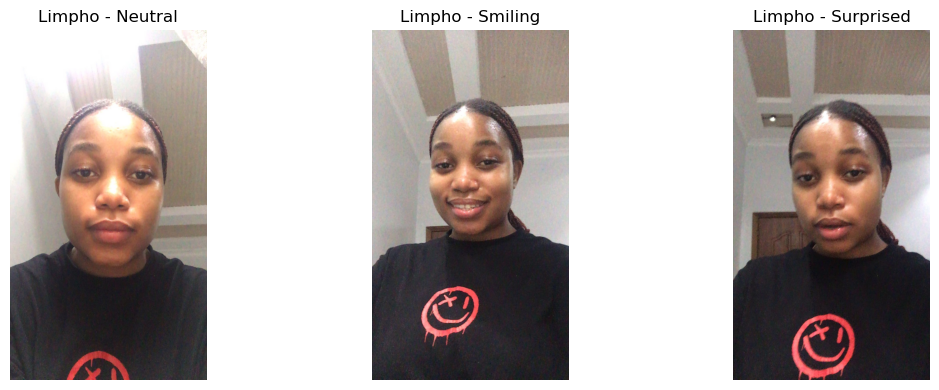


👤 Person: Orpheus
----------------------------------------
  ✅ Loaded: Neutral (orpheus-neutral.jpeg) - Shape: (2560, 1152, 3)
  ✅ Loaded: Smiling (orpheus-smiling.jpeg) - Shape: (2560, 1152, 3)
  ✅ Loaded: Surprised (orpheus-surprised.jpeg) - Shape: (2560, 1152, 3)
  ✅ Loaded: Surprised (orpheus-surprised.jpeg) - Shape: (2560, 1152, 3)


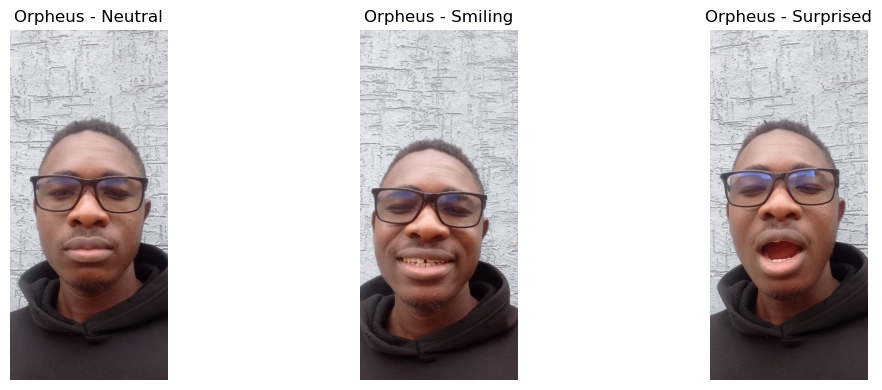


👤 Person: Christian
----------------------------------------
  ✅ Loaded: Neutral (Christian.jpg) - Shape: (393, 390, 3)
  ✅ Loaded: Smiling (Christian Smiling pic.jpeg) - Shape: (362, 390, 3)
  ✅ Loaded: Surprised (Christian surprised pic.jpeg) - Shape: (365, 390, 3)


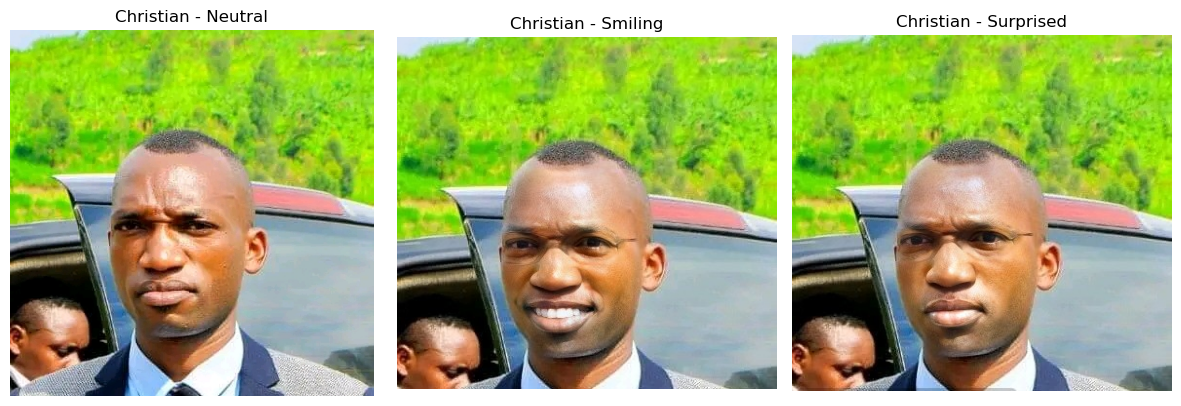


👤 Person: Henriette
----------------------------------------
  ✅ Loaded: Neutral (henriette_normal.jpeg) - Shape: (3088, 2316, 3)
  ✅ Loaded: Smiling (henriette_smiling.jpeg) - Shape: (3088, 2316, 3)
  ✅ Loaded: Neutral (henriette_normal.jpeg) - Shape: (3088, 2316, 3)
  ✅ Loaded: Smiling (henriette_smiling.jpeg) - Shape: (3088, 2316, 3)
  ✅ Loaded: Surprised (henriette_surprised.jpeg) - Shape: (3088, 2316, 3)
  ✅ Loaded: Surprised (henriette_surprised.jpeg) - Shape: (3088, 2316, 3)


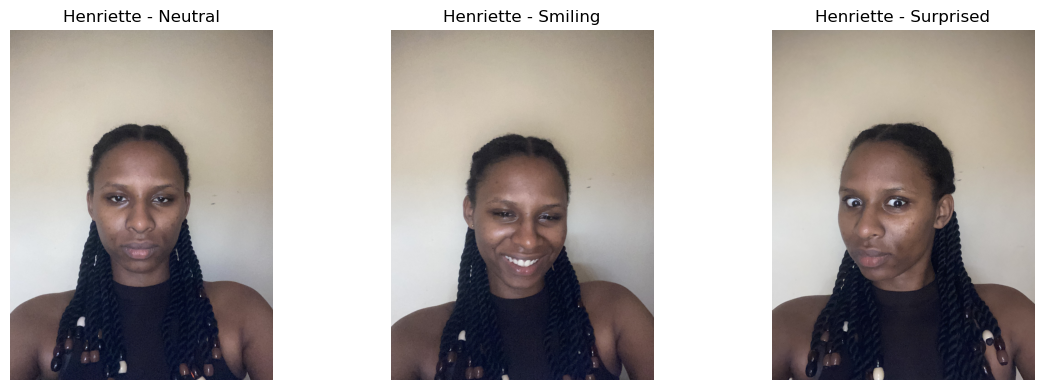


Total people: 4
Images per person: 3 (neutral, smiling, surprised)


In [7]:
# Define image structure: {person_name: [neutral, smiling, surprised]}

images_dict = {
    "Limpho": ["limpho-neutral.jpeg", "limpho-smiling.jpeg", "limpho-suprised.jpeg"],
    "Orpheus": ["orpheus-neutral.jpeg", "orpheus-smiling.jpeg", "orpheus-surprised.jpeg"],
    "Christian": ["Christian.jpg", "Christian Smiling pic.jpeg", "Christian surprised pic.jpeg"],
    "Henriette": ["henriette_normal.jpeg", "henriette_smiling.jpeg","henriette_surprised.jpeg"]
}

# Load and display images
print("="*60)
print("LOADING FACIAL IMAGES")
print("="*60)

for person_name, image_files in images_dict.items():
    print(f"\n👤 Person: {person_name}")
    print("-" * 40)
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    expressions = ["Neutral", "Smiling", "Surprised"]
    
    for idx, (img_file, expr) in enumerate(zip(image_files, expressions)):
        image_path = os.path.join("faces", img_file)
        
        try:
            # Handle HEIC files by converting to RGB first
            if img_file.lower().endswith('.heic'):
                from PIL import Image, ImageOps
                pil_img = Image.open(image_path)
                # Auto-rotate based on EXIF orientation
                pil_img = ImageOps.exif_transpose(pil_img)
                img = np.array(pil_img.convert('RGB'))
            else:
                # Load image and fix orientation
                from PIL import Image, ImageOps
                pil_img = Image.open(image_path)
                pil_img = ImageOps.exif_transpose(pil_img)
                img = np.array(pil_img.convert('RGB'))
            
            # Display image
            axes[idx].imshow(img)
            axes[idx].set_title(f"{person_name} - {expr}")
            axes[idx].axis('off')
            
            print(f"  ✅ Loaded: {expr} ({img_file}) - Shape: {img.shape}")
        except FileNotFoundError:
            print(f"  ❌ ERROR: File not found: {img_file}")
            axes[idx].text(0.5, 0.5, 'File Not Found', ha='center', va='center')
            axes[idx].axis('off')
        except Exception as e:
            print(f"  ❌ ERROR loading {img_file}: {str(e)}")
            axes[idx].text(0.5, 0.5, f'Error: {str(e)[:30]}', ha='center', va='center', fontsize=8)
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

print(f"\n{'='*60}")
print(f"Total people: {len(images_dict)}")
print(f"Images per person: 3 (neutral, smiling, surprised)")
print(f"{'='*60}")

## Apply Image Augmentations
**Generate augmented versions: rotation, flipping, grayscale**

In [8]:
def augment_image(img):
    """
    Generate augmented versions of an image
    Returns: list of augmented images
    """
    augmentations = []
    
    # 1. Horizontal flip
    flipped = cv2.flip(img, 1)
    augmentations.append(("flipped", flipped))
    
    # 2. Rotation (+15 degrees)
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, 15, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h))
    augmentations.append(("rotated_15", rotated))
    
    # 3. Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    augmentations.append(("grayscale", gray_rgb))
    
    return augmentations

# Extract face encodings from all images (original + augmented)
encodings = []
labels = []
image_metadata = []

print("\n" + "="*60)
print("EXTRACTING FACE ENCODINGS")
print("="*60)

for person_name, image_files in images_dict.items():
    print(f"\n👤 Processing: {person_name}")
    print("-" * 40)
    
    for img_file in image_files:
        image_path = os.path.join("faces", img_file)
        
        # Handle HEIC files and fix orientation
        try:
            from PIL import Image, ImageOps
            pil_img = Image.open(image_path)
            # Auto-rotate based on EXIF orientation
            pil_img = ImageOps.exif_transpose(pil_img)
            img = np.array(pil_img.convert('RGB'))
        except Exception as e:
            print(f"  ❌ ERROR loading {img_file}: {str(e)}")
            continue
            
        expression = img_file.split('.')[0]
        
        # Extract encoding from ORIGINAL image
        encoding = face_recognition.face_encodings(img)
        if len(encoding) > 0:
            encodings.append(encoding[0])
            labels.append(person_name)  # LABEL IS PERSON NAME, not expression
            image_metadata.append({
                'person': person_name,
                'expression': expression,
                'augmentation': 'original'
            })
            print(f"  ✅ Original ({expression}): Encoding extracted")
        
        # Apply augmentations and extract encodings
        augmented_imgs = augment_image(img)
        for aug_name, aug_img in augmented_imgs:
            aug_encoding = face_recognition.face_encodings(aug_img)
            if len(aug_encoding) > 0:
                encodings.append(aug_encoding[0])
                labels.append(person_name)  # LABEL IS PERSON NAME
                image_metadata.append({
                    'person': person_name,
                    'expression': expression,
                    'augmentation': aug_name
                })
                print(f"  ✅ {aug_name} ({expression}): Encoding extracted")

print(f"\n{'='*60}")
print(f"Total encodings extracted: {len(encodings)}")
print(f"Shape of each encoding: {encodings[0].shape}")
print(f"{'='*60}")


EXTRACTING FACE ENCODINGS

👤 Processing: Limpho
----------------------------------------
  ✅ Original (limpho-neutral): Encoding extracted
  ✅ Original (limpho-neutral): Encoding extracted
  ✅ flipped (limpho-neutral): Encoding extracted
  ✅ flipped (limpho-neutral): Encoding extracted
  ✅ rotated_15 (limpho-neutral): Encoding extracted
  ✅ rotated_15 (limpho-neutral): Encoding extracted
  ✅ grayscale (limpho-neutral): Encoding extracted
  ✅ grayscale (limpho-neutral): Encoding extracted
  ✅ Original (limpho-smiling): Encoding extracted
  ✅ Original (limpho-smiling): Encoding extracted
  ✅ flipped (limpho-smiling): Encoding extracted
  ✅ flipped (limpho-smiling): Encoding extracted
  ✅ rotated_15 (limpho-smiling): Encoding extracted
  ✅ rotated_15 (limpho-smiling): Encoding extracted
  ✅ grayscale (limpho-smiling): Encoding extracted
  ✅ grayscale (limpho-smiling): Encoding extracted
  ✅ Original (limpho-suprised): Encoding extracted
  ✅ Original (limpho-suprised): Encoding extracted


## Save Image Features to CSV
**Save 128D face encodings (embeddings) to image_features.csv**

In [13]:
# Create DataFrame with encodings
X = np.array(encodings)
y = np.array(labels)

# Create CSV with all 128 feature columns + label
df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(128)])
df['label'] = y

# Add metadata for reference
metadata_df = pd.DataFrame(image_metadata)
df = pd.concat([df, metadata_df], axis=1)

# Save to CSV
df.to_csv("image_features.csv", index=False)

print("\n" + "="*60)
print("IMAGE FEATURES SAVED")
print("="*60)
print(f"File: image_features.csv")
print(f"Total samples: {len(df)}")
print(f"Features per sample: 128 (face encoding dimensions)")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nLabel distribution:")
print(df['label'].value_counts())
print("="*60)


IMAGE FEATURES SAVED
File: image_features.csv
Total samples: 48
Features per sample: 128 (face encoding dimensions)

First few rows:
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0  -0.133170   0.052541   0.111882  -0.024103  -0.057176  -0.045780   
1  -0.130408   0.043543   0.105536  -0.026004  -0.069711  -0.041943   
2  -0.133845   0.053052   0.112961  -0.025009  -0.058437  -0.046497   
3  -0.125520   0.069812   0.082240  -0.013260  -0.061594  -0.043085   
4  -0.194665   0.062627   0.108870  -0.085083  -0.105489  -0.041904   

   feature_6  feature_7  feature_8  feature_9  ...  feature_122  feature_123  \
0   0.044704  -0.099913   0.193357  -0.118751  ...    -0.096674    -0.027975   
1   0.037159  -0.110916   0.193008  -0.123864  ...    -0.093969    -0.016775   
2   0.044063  -0.101236   0.192590  -0.119933  ...    -0.096023    -0.027324   
3   0.051024  -0.105555   0.212234  -0.131481  ...    -0.109917    -0.048865   
4   0.032267  -0.097335   0.142836  -0.

## Train Face Recognition Model
**Train classifier to recognize individuals (not expressions)**

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Prepare features and labels
X_features = df[[f'feature_{i}' for i in range(128)]].values
y_labels = df['label'].values

print("="*60)
print("TRAINING FACE RECOGNITION MODEL")
print("="*60)
print(f"\nDataset shape: {X_features.shape}")
print(f"Number of people: {len(np.unique(y_labels))}")
print(f"People: {np.unique(y_labels)}")

if len(np.unique(y_labels)) > 1:
    # Split data (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(
        X_features, y_labels, test_size=0.2, random_state=42, stratify=y_labels
    )
    
    print(f"\nTraining samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    
    # Train SVM classifier
    clf = SVC(kernel='linear', probability=True, random_state=42)
    clf.fit(X_train, y_train)
    
    # Evaluate
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\n{'='*60}")
    print(f"Model Accuracy: {accuracy:.2%}")
    print(f"{'='*60}\n")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
else:
    # Only one person - train on all data (for demo purposes)
    print("\n⚠️  WARNING: Only ONE person in dataset!")
    print("For real face recognition, you need multiple people.")
    print("Training on all data for demonstration...\n")
    
    clf = SVC(kernel='linear', probability=True, random_state=42)
    clf.fit(X_features, y_labels)
    
    print("✅ Model trained on all samples")
    print(f"Person recognized: {np.unique(y_labels)[0]}")

print("="*60)

TRAINING FACE RECOGNITION MODEL

Dataset shape: (48, 128)
Number of people: 4
People: ['Christian' 'Henriette' 'Limpho' 'Orpheus']

Training samples: 38
Test samples: 10

Model Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

   Christian       1.00      1.00      1.00         3
   Henriette       1.00      1.00      1.00         2
      Limpho       1.00      1.00      1.00         3
     Orpheus       1.00      1.00      1.00         2

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10


Confusion Matrix:
[[3 0 0 0]
 [0 2 0 0]
 [0 0 3 0]
 [0 0 0 2]]


## Face Authentication Test
**Test if a face matches a known user**

## Batch Authentication Test
**Test multiple images at once to verify unknown detection**

In [15]:
# Function to authenticate a face
def authenticate_face(image_path, show_details=True):
    """
    Authenticate a face from an image
    Returns: (is_authorized, person_name, confidence, distance)
    """
    try:
        img = face_recognition.load_image_file(image_path)
        encodings_found = face_recognition.face_encodings(img)
        
        if len(encodings_found) == 0:
            if show_details:
                print(f"❌ No face detected in {image_path}")
            return False, "NO_FACE", 0.0, 1.0
        
        test_enc = encodings_found[0]
        
        # Predict
        predicted = clf.predict([test_enc])[0]
        probs = clf.predict_proba([test_enc])[0]
        conf = max(probs)
        
        # Calculate distance
        distances = [face_recognition.face_distance([enc], test_enc)[0] for enc in encodings]
        min_dist = min(distances)
        
        # Thresholds
        CONF_THRESH = 0.60
        DIST_THRESH = 0.6
        
        is_authorized = (conf >= CONF_THRESH and min_dist < DIST_THRESH)
        
        if show_details:
            print(f"\n{'='*50}")
            print(f"Image: {image_path}")
            print(f"Predicted: {predicted} | Confidence: {conf:.2%} | Distance: {min_dist:.3f}")
            if is_authorized:
                print(f"✅ AUTHORIZED as {predicted}")
            else:
                print(f"❌ DENIED - Unknown person or low confidence")
        
        return is_authorized, predicted if is_authorized else "UNKNOWN", conf, min_dist
        
    except Exception as e:
        if show_details:
            print(f"❌ Error processing {image_path}: {e}")
        return False, "ERROR", 0.0, 1.0

# Test multiple images
test_images = [
    "test_images/download.jpeg",
    "faces/Christian.jpg",
    "faces/limpho-suprised.jpeg",
    "faces/orpheus-neutral.jpeg",
    "test_images/neutral.png",
    "test_images/getimages.jpeg",
    "faces/henriette_surprised.jpeg"
]

# Clear marker for new run
from datetime import datetime
print(f"🆕 NEW RUN - {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

print("\n" + "="*60)
print("BATCH AUTHENTICATION TEST")
print("="*60)
print(f"Testing {len(test_images)} images...")

results = []
for i, img_path in enumerate(test_images, 1):
    print(f"\n[{i}/{len(test_images)}] Testing: {img_path}")
    authorized, person, conf, dist = authenticate_face(img_path, show_details=False)
    
    # Show result inline
    status = "✅ AUTHORIZED" if authorized else "❌ DENIED"
    print(f"    Result: {status} | Person: {person} | Conf: {conf:.2%} | Dist: {dist:.3f}")
    
    results.append({
        'image': img_path,
        'authorized': authorized,
        'person': person,
        'confidence': conf,
        'distance': dist
    })

# Summary
print("\n" + "="*60)
print("SUMMARY TABLE")
print("="*60)
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))
print(f"\n✅ Authorized: {sum(results_df['authorized'])}/{len(results_df)}")
print(f"❌ Denied: {len(results_df) - sum(results_df['authorized'])}/{len(results_df)}")
print("="*60)

🆕 NEW RUN - 2025-11-14 16:18:17

BATCH AUTHENTICATION TEST
Testing 7 images...

[1/7] Testing: test_images/download.jpeg
    Result: ❌ DENIED | Person: UNKNOWN | Conf: 39.64% | Dist: 0.780

[2/7] Testing: faces/Christian.jpg
    Result: ✅ AUTHORIZED | Person: Christian | Conf: 81.20% | Dist: 0.000

[3/7] Testing: faces/limpho-suprised.jpeg
    Result: ❌ DENIED | Person: UNKNOWN | Conf: 39.64% | Dist: 0.780

[2/7] Testing: faces/Christian.jpg
    Result: ✅ AUTHORIZED | Person: Christian | Conf: 81.20% | Dist: 0.000

[3/7] Testing: faces/limpho-suprised.jpeg
    Result: ✅ AUTHORIZED | Person: Limpho | Conf: 79.53% | Dist: 0.000

[4/7] Testing: faces/orpheus-neutral.jpeg
    Result: ✅ AUTHORIZED | Person: Limpho | Conf: 79.53% | Dist: 0.000

[4/7] Testing: faces/orpheus-neutral.jpeg
    Result: ✅ AUTHORIZED | Person: Orpheus | Conf: 79.87% | Dist: 0.000

[5/7] Testing: test_images/neutral.png
    Result: ✅ AUTHORIZED | Person: Orpheus | Conf: 79.87% | Dist: 0.000

[5/7] Testing: test_imag

## Diagnostic: Investigate Low Confidence Issues
**Debug why training images fail authentication**

In [16]:
def diagnose_image(image_path):
    """
    Detailed diagnostic for why an image might fail authentication
    """
    print(f"\n{'='*70}")
    print(f"DIAGNOSTIC REPORT: {image_path}")
    print(f"{'='*70}")
    
    try:
        # Load image
        img = face_recognition.load_image_file(image_path)
        print(f"✅ Image loaded successfully")
        print(f"   Image shape: {img.shape}")
        
        # Detect faces
        encodings_found = face_recognition.face_encodings(img)
        print(f"\n📊 Face Detection:")
        print(f"   Faces found: {len(encodings_found)}")
        
        if len(encodings_found) == 0:
            print(f"   ❌ NO FACE DETECTED - Possible reasons:")
            print(f"      • Image too blurry or low resolution")
            print(f"      • Face not clearly visible")
            print(f"      • Extreme lighting conditions")
            print(f"      • Face too small in the image")
            return
        
        test_enc = encodings_found[0]
        print(f"   ✅ Face encoding extracted (128D vector)")
        
        # Predict
        predicted = clf.predict([test_enc])[0]
        probs = clf.predict_proba([test_enc])[0]
        conf = max(probs)
        
        print(f"\n🎯 Classification Results:")
        print(f"   Predicted Person: {predicted}")
        print(f"   Confidence: {conf:.2%}")
        
        # Show all class probabilities
        print(f"\n   Probability breakdown:")
        classes = clf.classes_
        for person, prob in zip(classes, probs):
            bar = "█" * int(prob * 50)
            print(f"      {person:12s}: {prob:6.2%} {bar}")
        
        # Calculate distances to all training samples
        distances = [face_recognition.face_distance([enc], test_enc)[0] for enc in encodings]
        min_dist = min(distances)
        avg_dist = np.mean(distances)
        
        print(f"\n📏 Distance Metrics:")
        print(f"   Min distance to training samples: {min_dist:.4f}")
        print(f"   Avg distance to training samples: {avg_dist:.4f}")
        print(f"   Distance threshold: 0.6000")
        
        # Check which training samples are closest
        sorted_indices = np.argsort(distances)[:5]
        print(f"\n🔍 5 Closest Training Samples:")
        for i, idx in enumerate(sorted_indices, 1):
            person = labels[idx]
            dist = distances[idx]
            meta = image_metadata[idx]
            print(f"   {i}. {person:12s} | Dist: {dist:.4f} | {meta['expression']:20s} | {meta['augmentation']}")
        
        # Authentication verdict
        print(f"\n⚖️  Authentication Decision:")
        conf_pass = conf >= 0.60
        dist_pass = min_dist < 0.6
        
        print(f"   Confidence check: {'✅ PASS' if conf_pass else '❌ FAIL'} ({conf:.2%} {'≥' if conf_pass else '<'} 60%)")
        print(f"   Distance check:   {'✅ PASS' if dist_pass else '❌ FAIL'} ({min_dist:.4f} {'<' if dist_pass else '≥'} 0.6)")
        
        if conf_pass and dist_pass:
            print(f"\n   🟢 RESULT: AUTHORIZED as {predicted}")
        else:
            print(f"\n   🔴 RESULT: DENIED")
            print(f"\n   💡 Recommendations:")
            if not conf_pass:
                print(f"      • Low confidence suggests face doesn't match training well")
                print(f"      • Try adding more training images with similar expressions/angles")
                print(f"      • Consider lowering confidence threshold (risky - more false positives)")
            if not dist_pass:
                print(f"      • High distance means face encoding is far from training samples")
                print(f"      • Add more diverse augmentations during training")
        
    except Exception as e:
        print(f"❌ ERROR: {str(e)}")
        import traceback
        traceback.print_exc()
    
    print(f"{'='*70}\n")

# Test the problematic image
diagnose_image("faces/henriette_surprised.jpeg")


DIAGNOSTIC REPORT: faces/henriette_surprised.jpeg
✅ Image loaded successfully
   Image shape: (2316, 3088, 3)

📊 Face Detection:
   Faces found: 0
   ❌ NO FACE DETECTED - Possible reasons:
      • Image too blurry or low resolution
      • Face not clearly visible
      • Extreme lighting conditions
      • Face too small in the image

📊 Face Detection:
   Faces found: 0
   ❌ NO FACE DETECTED - Possible reasons:
      • Image too blurry or low resolution
      • Face not clearly visible
      • Extreme lighting conditions
      • Face too small in the image


## Save Trained Model
**Save for deployment/future use**

In [18]:
import pickle

# Save the trained model
model_data = {
    'classifier': clf,
    'label_encoder': np.unique(y_labels).tolist()
}

with open('face_recognition_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print(" Model saved to 'face_recognition_model.pkl'")
print(f"   Trained to recognize: {np.unique(y_labels)}")

 Model saved to 'face_recognition_model.pkl'
   Trained to recognize: ['Christian' 'Henriette' 'Limpho' 'Orpheus']
